In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pandas.plotting import parallel_coordinates
import pytz, nltk
from pytz import common_timezones, all_timezones

import scipy as sp
import scipy.stats as stats
import pylab



import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
matplotlib.style.use('seaborn-talk')
matplotlib.style.use('fivethirtyeight');


import scipy
import os
import plotly
plotly.offline.init_notebook_mode(connected=True)

# Load Training Data

In [2]:
import sqlite3

with sqlite3.connect('turbofandata.db') as connection:
    dftrain = pd.read_sql('SELECT * from dftrain', connection)

# Survival Analysis for Predictive Analysis

Use the turbofan dataset from the NASA Prognostics Center of Excellence.
This data set consists of four types, each with their own set of failure modes.
Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. 
```
1)  unit number
2)  time, in cycles
3)  operational setting 1
4)  operational setting 2
5)  operational setting 3
6)  sensor measurement  1
7)  sensor measurement  2
...
26) sensor measurement  26
```

Each row corresponds to a set of sensor values, a slice at a particular point in time. But what matters is not what time it is, based on some arbitrary origin.
What matters is the "Remaining Useful Life" (RUL) for each row of sensor readings.


In [3]:
dftrain.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,1fd_001
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,1fd_001
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,1fd_001
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,1fd_001
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,1fd_001


Each run has a unique **id** and the last row corresponds to failure/breakdown:

In [4]:
dftrain.tail()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id
160354,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8.4541,0.03,372,2319,100.0,29.11,17.5234,4,0,249fd_004
160355,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8.2221,0.03,396,2388,100.0,39.38,23.7151,3,0,249fd_004
160356,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8.2525,0.03,395,2388,100.0,39.78,23.8270,2,0,249fd_004
160357,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,9.0515,0.02,337,2223,100.0,15.26,9.0774,1,0,249fd_004
160358,249,255,42.0030,0.8400,100.0,445.00,549.85,1369.75,1147.45,3.91,...,9.1207,0.02,333,2212,100.0,10.66,6.4341,0,1,249fd_004


# Neural Network

Use a NN to train a classfier with a new type of target. Instead of **breakdown**, make a new binary target capturing whether it will fail within the next TTF **time_cycles** (Time to Failure)

In [5]:
dftrain.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,1fd_001
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,1fd_001
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,1fd_001
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,1fd_001
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,1fd_001


In [6]:
dftrain.columns

Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21', 'RUL', 'breakdown', 'id'],
      dtype='object')

In [7]:
TTF = 10 # Can change this to get more or less "lead time"; ideally want it to be as large as possible
# as large as the data supports ; as long as there are patterns in the data that the NN can leverge to
# produce a highly/eerily accurate model.

**RUL** = Remaining Useful Life

The new **label** target is 1 whenever the Remaining Useful Life is less than TTF, and 0 otherwise.

In [8]:
TTF = 10 # Can change this parameter to get more or less "lead time"
# if the data has a enough pre-cursor signal, you can increase TTF
# whether there is enough signal is determined by the evalation
# metrics of the predictive model
dftrain['label'] = np.where(dftrain['RUL'] <= TTF, 1, 0 )
#dftrain.tail(15)

In [9]:
dftrain.tail(15)

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id,label
160344,249,241,20.0022,0.7003,100.0,491.19,607.48,1491.67,1258.61,9.35,...,0.03,367,2324,100.00,24.75,14.9042,14,0,249fd_004,0
160345,249,242,9.9980,0.2500,100.0,489.05,605.18,1504.41,1319.18,10.52,...,0.03,371,2319,100.00,28.97,17.3846,13,0,249fd_004,0
160346,249,243,35.0048,0.8400,100.0,449.44,555.96,1371.87,1146.58,5.48,...,0.02,336,2223,100.00,14.88,9.0603,12,0,249fd_004,0
160347,249,244,41.9990,0.8406,100.0,445.00,549.17,1366.56,1140.47,3.91,...,0.02,334,2212,100.00,10.64,6.4689,11,0,249fd_004,0
160348,249,245,42.0009,0.8400,100.0,445.00,549.68,1364.54,1140.37,3.91,...,0.02,334,2212,100.00,10.65,6.4700,10,0,249fd_004,1
160349,249,246,42.0049,0.8400,100.0,445.00,549.66,1360.69,1143.75,3.91,...,0.02,335,2212,100.00,10.74,6.4258,9,0,249fd_004,1
160350,249,247,41.9997,0.8409,100.0,445.00,549.79,1359.28,1139.92,3.91,...,0.02,334,2212,100.00,10.71,6.4422,8,0,249fd_004,1
160351,249,248,20.0016,0.7011,100.0,491.19,607.49,1494.10,1265.20,9.35,...,0.03,368,2324,100.00,24.89,14.9015,7,0,249fd_004,1
160352,249,249,42.0046,0.8405,100.0,445.00,549.34,1365.59,1138.33,3.91,...,0.02,333,2212,100.00,10.88,6.4530,6,0,249fd_004,1
160353,249,250,25.0000,0.6200,60.0,462.54,537.34,1269.56,1057.40,7.05,...,0.02,307,1915,84.93,14.55,8.6805,5,0,249fd_004,1


Train a model that for each row, consisting of the meaningful set of input columns and their values, predicts where the label is **0** (more than TTF RULs left) or **1** (less than or equal to TTF RULs left).

In [10]:
#input_cols = ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
#       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
#       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
#       's_21']
input_cols = ['setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']
#output_cols = ['breakdown']
output_cols = ['label']


The **breakdown** column is an indicator variable where 0 indicates the engine is operational, and 1 indicates that it has failed.

In [11]:
dftrain['breakdown'].value_counts()


0    159650
1       709
Name: breakdown, dtype: int64

In [12]:
dftrain['label'].value_counts()


0    152560
1      7799
Name: label, dtype: int64

Create an explicit **validation** set of some subset of ids in dftrain:

set the random seed to ensure reproducibility.

In [13]:
np.random.seed(2020)
ids = dftrain['id'].unique()
np.random.shuffle(ids)
len(ids)
ids[:10]

array(['26fd_004', '127fd_002', '39fd_004', '164fd_004', '10fd_002',
       '55fd_001', '77fd_001', '193fd_002', '95fd_002', '227fd_004'],
      dtype=object)

In [14]:
VAL_SIZE = 0.25
val_index = int(len(ids)*VAL_SIZE)
val_ids = ids[:val_index]
dfval = dftrain[dftrain.id.isin(val_ids)].copy()
dfval.id.nunique()

177

In [15]:
dftrain.id.nunique()

709

In [16]:
dftrain = dftrain[~dftrain.id.isin(val_ids)].copy()
dftrain.id.nunique()

532

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer



y = dftrain[output_cols].to_numpy()
y = np.ravel(y)
X = dftrain[input_cols].to_numpy()


In [20]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install tensorflow

In [21]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
from keras.utils.vis_utils import plot_model

#import xgboost
import time
from tqdm import tqdm


First break up into a training and test set, then address the class imbalance problem
on just the training set.

In [22]:


X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,
                        random_state=17,test_size=0.25)


In [23]:
# just under 5% of the data corresponds to the low RUL cases
# class imbalance problem, difficult for a model
# to learn the precursor signals in this case
# -> Oversample that class

pd.Series(y_train).value_counts(normalize=True)


0    0.951323
1    0.048677
dtype: float64

In [24]:
pd.Series(y_test).value_counts(normalize=True)

0    0.951324
1    0.048676
dtype: float64

In [25]:
#!{sys.executable} -m pip install imblearn

Apply the StandardScaler normalization **BEFORE** oversampling or SMOTE.

In [26]:
scaler_xtrain = StandardScaler()
scaler_xtrain.fit(X_train)
X_train_norm = scaler_xtrain.transform(X_train) 
X_test_norm = scaler_xtrain.transform(X_test)


from imblearn.over_sampling import SMOTE

USE_SMOTE = False
USE_ROS = True

if USE_SMOTE:

    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='minority')
    #smote = SMOTE(sampling_strategy=0.5)
    X_train_sm, y_train_sm = smote.fit_sample(X_train_norm, y_train)



if USE_ROS:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_train_sm, y_train_sm = ros.fit_sample(X_train_norm, y_train)


In [27]:
pd.Series(y_train_sm).value_counts()

1    85777
0    85777
dtype: int64

In [28]:
X_train_sm.shape, y_train_sm.shape

((171554, 24), (171554,))

* X_train_sm, y_train_sm
* X_test_norm, y_test
* scaler_xtrain

In [29]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import keras
from keras import layers
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers

In [30]:
X_train_sm.shape[1:], X_train_norm.shape[1], X_train_sm.shape


((24,), 24, (171554, 24))

Design a deep neural network, a binary classifier. Lots of choices on which architecture to use. Here is one with 6,791 trainable parameters:

In [31]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy')

model = Sequential()
model.add(Dense(50, input_dim=X_train_sm.shape[1], activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dropout(0.1))
model.add(Dense(45,activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dense(45, activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dropout(0.1))
model.add(Dense(25,  activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dense(1, activation='sigmoid'))




opt_defaultparams = keras.optimizers.Adamax(learning_rate=0.001,
                             beta_1=0.9, beta_2=0.999,
                    epsilon=1e-07, name="Adamax")

opt = keras.optimizers.Adamax(learning_rate=0.0005,
                             beta_1=0.9, beta_2=0.999,
                    epsilon=1e-07, name="Adamax")



model.compile(optimizer=opt_defaultparams,
                 loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1250      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                2295      
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1150      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2

evaluate the cell below multiple times; increasing the batch size
with each iteration.

Design a deep neural network, a binary classifier. Lots of choices on which architecture to use. Here is one with 6,791 trainable parameters:

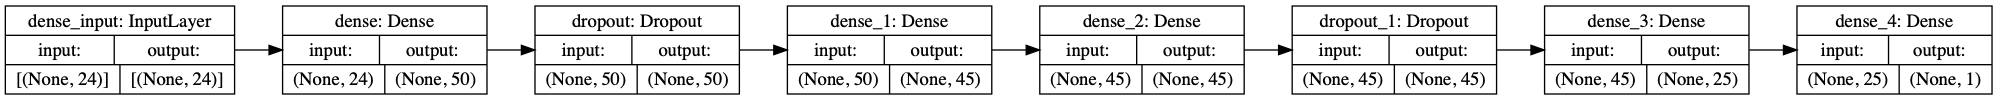

In [32]:
plot_model(model,
          to_file='model_plot.png',
          show_shapes=True,
        rankdir='LR',
          show_layer_names=True)

In [33]:
from IPython.display import Image

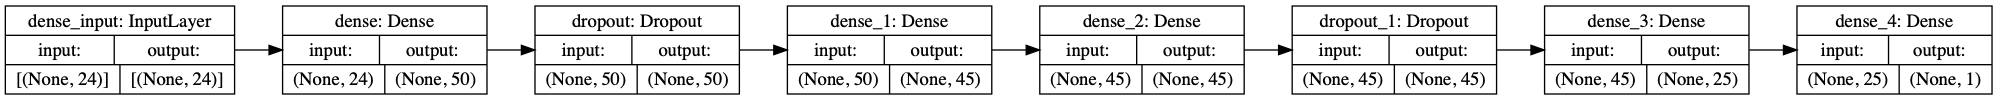

In [34]:
Image('model_plot.png')

In [35]:
batch_sizes = [8,8,16,16,32,32,64,64,128,128,256,256,512,512,1024,1024,1024]

for b in batch_sizes:
    history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=b)

Epoch 1/5000
21445/21445 [==============================] - 27s 1ms/step - loss: 0.3026 - accuracy: 0.8604 - val_loss: 0.1468 - val_accuracy: 0.9349
Epoch 2/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.1277 - accuracy: 0.9537 - val_loss: 0.1720 - val_accuracy: 0.9306
Epoch 1/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.1132 - accuracy: 0.9595 - val_loss: 0.1236 - val_accuracy: 0.9467
Epoch 2/5000
21445/21445 [==============================] - 25s 1ms/step - loss: 0.1099 - accuracy: 0.9610 - val_loss: 0.1185 - val_accuracy: 0.9486
Epoch 3/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.1071 - accuracy: 0.9624 - val_loss: 0.1267 - val_accuracy: 0.9458
Epoch 1/5000
10723/10723 [==============================] - 13s 1ms/step - loss: 0.1036 - accuracy: 0.9641 - val_loss: 0.1241 - val_accuracy: 0.9476
Epoch 2/5000
10723/10723 [==============================] - 14s 1ms/step - loss: 0.1017 - accuracy: 0.9646

In [36]:
history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=2028)

Epoch 1/5000
85/85 [==============================] - 1s 6ms/step - loss: 0.0822 - accuracy: 0.9722 - val_loss: 0.1070 - val_accuracy: 0.9558
Epoch 2/5000
85/85 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9724 - val_loss: 0.1095 - val_accuracy: 0.9541


In [37]:
history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=5000)

Epoch 1/5000
35/35 [==============================] - 0s 12ms/step - loss: 0.0819 - accuracy: 0.9719 - val_loss: 0.1026 - val_accuracy: 0.9576
Epoch 2/5000
35/35 [==============================] - 0s 9ms/step - loss: 0.0808 - accuracy: 0.9726 - val_loss: 0.1028 - val_accuracy: 0.9567


In [38]:
import plotly.express as px

In [39]:
scoretrain = model.evaluate(X_train_sm, y_train_sm)
print(scoretrain)


5362/5362 [==============================] - 5s 985us/step - loss: 0.0775 - accuracy: 0.9739
[0.07746164500713348, 0.9739382266998291]


In [40]:
scoretest = model.evaluate(X_test_norm, y_test)
print(scoretest)



940/940 [==============================] - 1s 1ms/step - loss: 0.1028 - accuracy: 0.9567
[0.1028098613023758, 0.9566808342933655]


In [41]:
_, train_acc = model.evaluate(X_train_sm, y_train_sm, verbose=0)
_, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)


In [42]:
print(f" Train: {train_acc} , Test: {test_acc}")

 Train: 0.9739382266998291 , Test: 0.9566808342933655


In [43]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_norm, verbose=0)
# predict crips classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = (model.predict(X_test_norm, verbose=0) > 0.5).astype("int32") 

In [44]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# accuracy: (tp + tn ) / ( p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print(f"accuracy: {accuracy}")
# precision: tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print(f"precision: {precision}")
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print(f"Recall: {recall}")
# f1 = 2 tp / (2 tp + tp + fn)
f1 = f1_score(y_test, yhat_classes)
print(f"F1 score : {f1}")

accuracy: 0.956680862390205
precision: 0.5296500920810313
Recall: 0.9829118250170882
F1 score : 0.6883676400191479


In [45]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [46]:
def confusion_matrix(actual, predicted):
    plt.figure(figsize=(5,5))
    sns.heatmap(sklearn.metrics.confusion_matrix(actual,predicted),annot=True,fmt='.5g')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.show()


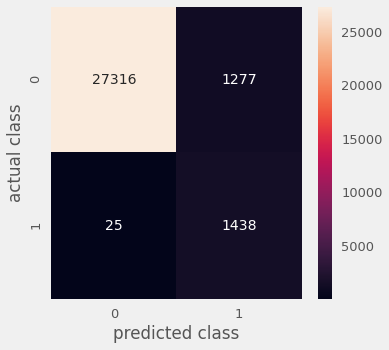

In [47]:
confusion_matrix(y_test, yhat_classes)

In [48]:
def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'expected profit {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 

In [49]:
expected_profit(y_test, yhat_classes)

TP =1438, TN = 27316, FP = 1277, FN = 25
expected profit 298700000


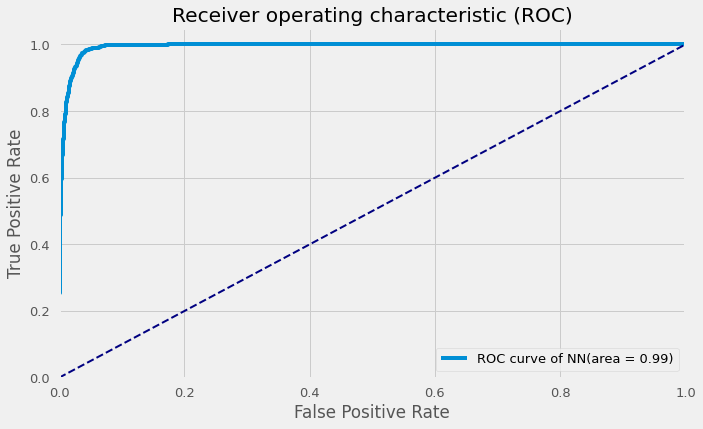

In [50]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of NN(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,  yhat_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     28593
           1       0.53      0.98      0.69      1463

    accuracy                           0.96     30056
   macro avg       0.76      0.97      0.83     30056
weighted avg       0.98      0.96      0.96     30056



# Evaluation metrics on the dfval dataset:

In [52]:
real_x_test = dfval[input_cols].to_numpy()
real_x_test_norm = scaler_xtrain.transform(real_x_test)

real_y_test = dfval[output_cols].to_numpy()
real_y_test = np.ravel(real_y_test)


# predict probabilities for test set
yhat_probs = model.predict(real_x_test_norm, verbose=0)
# predict crips classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = (model.predict(real_x_test_norm, verbose=0) > 0.5).astype("int32") 


# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn ) / ( p + n)
accuracy = accuracy_score(real_y_test, yhat_classes)
print(f"accuracy: {accuracy}")
# precision: tp / (tp + fp)
precision = precision_score(real_y_test, yhat_classes)
print(f"precision: {precision}")
# recall: tp / (tp + fn)
recall = recall_score(real_y_test, yhat_classes)
print(f"Recall: {recall}")
# f1 = 2 tp / (2 tp + tp + fn)
f1 = f1_score(real_y_test, yhat_classes)
print(f"F1 score : {f1}")

accuracy: 0.9600617883748163
precision: 0.5497685185185185
Recall: 0.9758602978941961
F1 score : 0.7033129742735518


Evaluation metrics of the trained model for the held-out validation set

Cohen's kappa: 0.6836833562364388
ROC AUC: 0.9931611708709716


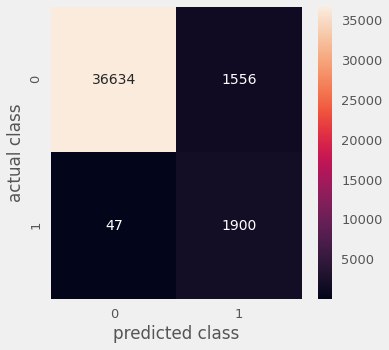

None


In [53]:
# kappa
kappa = cohen_kappa_score(real_y_test, yhat_classes)
print(f"Cohen's kappa: {kappa}")
# ROC AUC
auc = roc_auc_score(real_y_test, yhat_probs)
print(f"ROC AUC: {auc}")
# confusion matrix
conf_mat = confusion_matrix(real_y_test, yhat_classes)
print(conf_mat)

In [54]:
expected_profit(real_y_test, yhat_classes)

TP =1900, TN = 36634, FP = 1556, FN = 47
expected profit 405000000


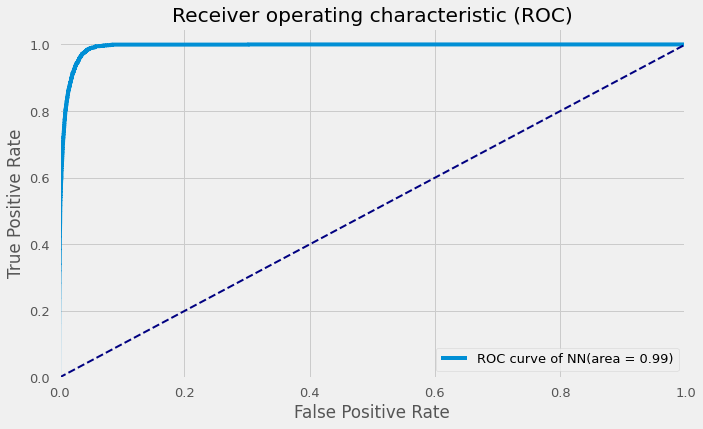

In [55]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(real_y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of NN(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [56]:
from sklearn.metrics import classification_report
print(classification_report(real_y_test,  yhat_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     38190
           1       0.55      0.98      0.70      1947

    accuracy                           0.96     40137
   macro avg       0.77      0.97      0.84     40137
weighted avg       0.98      0.96      0.97     40137



In [57]:
from sklearn.metrics import fowlkes_mallows_score

fmi_score = fowlkes_mallows_score(real_y_test,  yhat_classes)
print(fmi_score)


0.9568471789737548


In [58]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(real_y_test, yhat_probs)
print(roc_auc)


0.9931611708709716


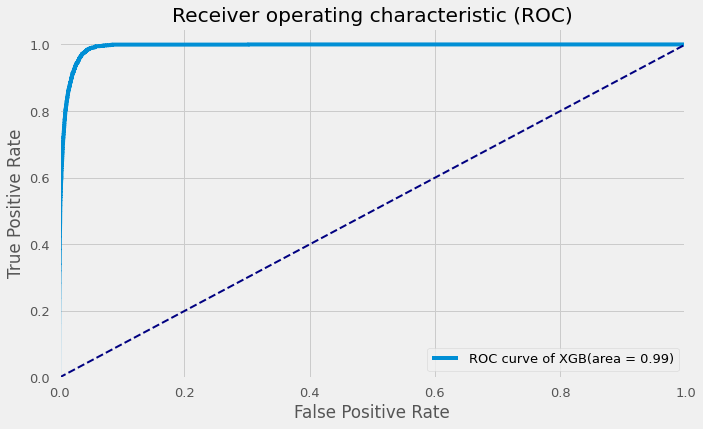

In [59]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(real_y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of XGB(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [60]:
yhat = model.predict(real_x_test_norm, verbose=0)

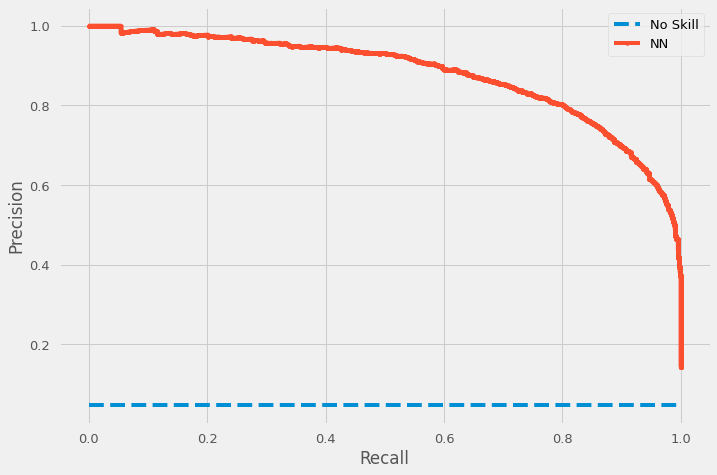

PR AUC 0.879557513746015


In [61]:
from matplotlib import pyplot
from sklearn.metrics import auc
#yhat = clf.predict_proba(real_x_test_norm)
yhat = model.predict(real_x_test_norm, verbose=0)

pos_probs = yhat
no_skill = len(real_y_test[real_y_test==1]) / len(real_y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(real_y_test, pos_probs)
# plot the model precision-recall curve
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='NN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"PR AUC {auc_score}")

# Save the model, the scaler object, and the dfval dataset

In [62]:
from keras.models import model_from_json
from keras.models import model_from_yaml
from pickle import load
from pickle import dump
import sqlite3

In [63]:
dump(scaler_xtrain, open('scaler_xtrain_notime.pkl', 'wb'))
model.save('model_notime.h5')



In [64]:
with sqlite3.connect('turbofandata.db') as connection:
    dfval.to_sql(
    'dfval_notime',connection,index=False,
    if_exists='replace')

In [65]:
from keras.models import load_model


In [66]:
model_new = load_model('model_notime.h5')
scaler_xtrain_new = load(open('scaler_xtrain_notime.pkl','rb'))

with sqlite3.connect('turbofandata.db') as connection:
    dfval_new = pd.read_sql('SELECT * from dfval_notime', connection)

In [67]:
try:
    os.mkdir('SURVIVALCURVES')
except:
    pass


In [68]:
def get_survival_function(identifier,dfval,input_cols,
                          scaler_xtrain, clf, make_plot = True, SHOW=True,
                         AUTO_OPEN=False):
    """Takes the input array X and the trained model.
    returns the predicted survival function."""
    X_0 = scaler_xtrain.transform(dfval[dfval.id == identifier][input_cols].to_numpy())
    #real_rul = dfval[dfval.id == identifier]['REAL_RUL']
    #print(X_0)
    hazards = clf.predict(X_0)
    A = []
    p_so_far = 1
    for i in range(len(hazards)):
        p_cur = hazards[i][0]
        A.append(p_so_far*(1 - p_cur))
        p_so_far = p_so_far*(1 - p_cur)
    As = pd.Series(A)
    As.name = identifier
    
    try:
        dq = dfval[dfval.id == identifier].copy()
        red = dq.groupby('label')['time_cycles'].min()
        t_red = red.loc[1] # the time_cycles value at which to add a red vertical line
    except:
        pass
    if make_plot:
        fig = px.line(As, title=f"survival curve for {identifier}")
        try:
            fig.update_layout(shapes=[
                   dict(
                   type='line',name='actual TTF start',
                   yref='paper', y0=0, y1=1,
                   xref='x', x0=t_red, x1=t_red)
               ])
            plotly.offline.plot(fig,auto_open=AUTO_OPEN,
                filename=f"SURVIVALCURVES/survival{identifier}.html")
        except:
            pass
        if SHOW:
            fig.show()
    df = pd.DataFrame(scaler_xtrain.inverse_transform(X_0), columns=input_cols)
    df['As'] = As
    df['hazard'] = [h[0] for h in hazards]
    # capture the information of when it really started to fail
    df['TRUE_START_OF_BREAKDOWN'] = t_red
    df.name = f"{identifier}"
    filename=f"SURVIVALCURVES/survival{identifier}.csv"
    df.to_csv(filename,index=False)
    
    dg = pd.DataFrame(X_0, columns=input_cols)
    dg['As'] = As
    dg['hazard'] = [h[0] for h in hazards]
    dg.name = f"{identifier}"
    return df, dg

Survival Curves:

For each combination of sensor readings, the model predicts the probablity of being in class **0** (where RUL > TTF) or class **1** (where RUL <= TTF).

This prediction is precisely the **hazard function** of classical survival analysis.


The hazard function can be written as



$\lambda( \mathbf{X}_{i}, t_{j} ) = P( Y = t_{j} | Y \geq t_{j}, \mathbf{X}_{i})$, 


the probablity that, if a satellite has not entered safe mode up until time $t_{j}$, they will in during that time. $Y$ represents the true surival time of the satellite.

It follows that 

$P(Y = t_{j} | \mathbf{X}_{i}) = \lambda(\mathbf{X}_{i}, t_{j}) \Pi_{k=1}^{j-1} (1 - \lambda(\mathbf{X}_{i}, t_{k}))$

Knowing 
$P(Y = t_{j} | \mathbf{X}_{i})$ for all $t_{j}$ gives the full probability distrubution of transitioning to safe mode at time Y. The survival function is then derived from this distribution as

$S(\mathbf{X}_{i}, t_{k}) = 1 - CDF(\mathbf{X}_{i}, t_{k})$

where
$CDF(\mathbf{X}_{i}, t_{k}) = \sum_{j=1}^{k} P(Y = t_{j} | \mathbf{X}_{i})$ is the cumulative density function.

This methodogy has been developed fully and applied to predicting cancer patients individual survival curves here: Personalized Prognostic Models for Oncology: A Machine Learning Approach (https://arxiv.org/abs/1606.07369 accessed 5 Sep 2020).

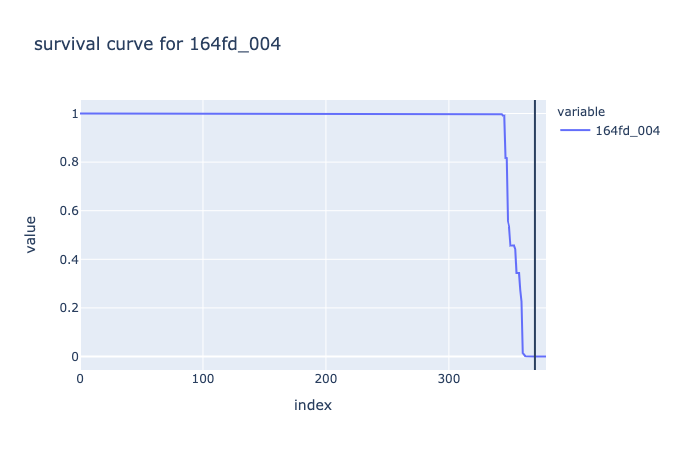

In [69]:
valids = dfval['id'].unique()
plotly.offline.init_notebook_mode(connected=True)
df, dg = get_survival_function(valids[150], dfval, input_cols,
                               scaler_xtrain, model,
                              SHOW=True, AUTO_OPEN=False)

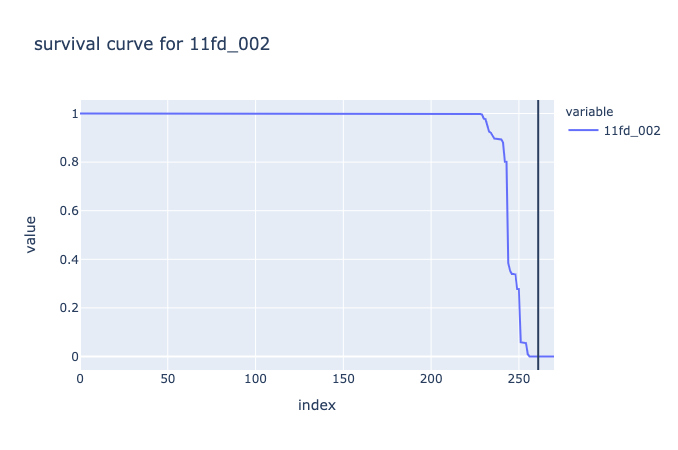

In [70]:
plotly.offline.init_notebook_mode(connected=True)
df, dg = get_survival_function(valids[27], dfval, input_cols,
                               scaler_xtrain, model,
                              SHOW=True, AUTO_OPEN=False)

Can cumulatively compute the dynamic survival function with streaming sensor input

In [71]:
try:
    os.mkdir('ANIMATEDSURVIVALCURVES')
except:
    pass

In [72]:
import matplotlib.animation as animation


In [73]:
def get_ani_function(identifier,dfval,input_cols,
                          scaler_xtrain, clf, make_plot = True, SHOW=True,
                         AUTO_OPEN=False):
    """Takes the input array X and the trained model.
    returns the predicted survival function."""
    X_0 = scaler_xtrain.transform(dfval[dfval.id == identifier][input_cols].to_numpy())
    #real_rul = dfval[dfval.id == identifier]['REAL_RUL']
    #print(X_0)
    hazards = clf.predict(X_0)
    A = []
    p_so_far = 1
    for i in range(len(hazards)):
        p_cur = hazards[i][0]
        A.append(p_so_far*(1 - p_cur))
        p_so_far = p_so_far*(1 - p_cur)
    As = pd.Series(A)
    As.name = identifier
    
    try:
        dq = dfval[dfval.id == identifier].copy()
        red = dq.groupby('label')['time_cycles'].min()
        t_red = red.loc[1] # the time_cycles value at which to add a red vertical line
    except:
        pass
    if make_plot:
        fig = px.line(As, title=f"survival curve for {identifier}")
        try:
            fig.update_layout(shapes=[
                   dict(
                   type='line',name='actual TTF start',
                   yref='paper', y0=0, y1=1,
                   xref='x', x0=t_red, x1=t_red)
               ])
            plotly.offline.plot(fig,auto_open=AUTO_OPEN,
                filename=f"ANIMATEDSURVIVALCURVES/survival{identifier}.html")
        except:
            pass
        if SHOW:
            fig.show()
    df = pd.DataFrame(scaler_xtrain.inverse_transform(X_0), columns=input_cols)
    df['As'] = As
    df['hazard'] = [h[0] for h in hazards]
    # capture the information of when it really started to fail
    df['TRUE_START_OF_BREAKDOWN'] = t_red
    df.name = f"{identifier}"
    filename=f"ANIMATEDSURVIVALCURVES/survival{identifier}.csv"
    df['As'] = As
    df.to_csv(filename,index=False)
    
    dg = pd.DataFrame(X_0, columns=input_cols)
    dg['As'] = As
    dg['hazard'] = [h[0] for h in hazards]
    dg.name = f"{identifier}"
    #
    #x = df['time_cycles'].to_numpy()
    x = df.reset_index().index
    y = df['As'].to_numpy()


    fig, ax = plt.subplots()
    line, = ax.plot(x, y, color='k')

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        #line.axes.axis([0, df['time_cycles'].max(), 0, df['As'].max()+.05])
        line.axes.axis([0, x.max(), 0, df['As'].max()+.05])
        return line,

    ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)

    ani.save(f'ANIMATEDSURVIVALCURVES/{df.name}.mp4')
    return ani


In [ ]:
from IPython.display import HTML
plotly.offline.init_notebook_mode(connected=True)
ani = get_ani_function(valids[27], dfval, input_cols,
                               scaler_xtrain, model,
                              SHOW=False, AUTO_OPEN=False)
HTML(ani.to_html5_video())

In [ ]:
model = load_model('model_notime.h5')
scaler_xtrain = load(open('scaler_xtrain_notime.pkl','rb'))

with sqlite3.connect('turbofandata.db') as connection:
    dfval = pd.read_sql('SELECT * from dfval_notime', connection)
    dftrain = pd.read_sql('SELECT * from dftrain', connection)
    dftest = pd.read_sql('SELECT * from dftest', connection)

In [ ]:
#input_cols = ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
#       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
#       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
#       's_21']

input_cols = ['setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']
#output_cols = ['breakdown']
output_cols = ['label']

In [ ]:
def get_all_paraplot(df,SHOW=False):
    dq = df[input_cols + ['RUL']].copy()
    fig = px.parallel_coordinates(dq,
                color='RUL',title=f"parallel_rul",
            color_continuous_scale=px.colors.
                                  diverging.Tealrose)
    plotly.offline.plot(fig, auto_open=True,
                   filename=f"parallel_rul.html")
    if SHOW:
        fig.show()

In [ ]:
#from IPython.display import HTML
#get_all_paraplot(dftrain,SHOW=True)